In [123]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [2]:
movie_path = 'data/Movie.pkl'
characters_path = 'data/Character.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)

with open(characters_path, 'rb') as file:
    Characters = pickle.load(file)

# Network analysis through time 

How is an actor network’s impacted during his career ?
What impacts this evolution ? ethnicity, gender, genre of movie
Impact of a specific movie on relation and network of actors ?

Here is the global stategy that we will use to analyse the evolution of Networks between actors:

1) Create networks using the list of actors that played in each film
2) Extract metrics form the networks
3) Do the same for each year
4) Analyse the evolution of the metrics from the networks and compare them with other informatrion on the actor carrer evolution

### 1. Create Networks

Use the `Characters` dataset to create new columns to the `Movie` dataset containing the list of the actors that played in each movie.

In [5]:
grouped_actors = Characters.groupby('Freebase_movie_ID').agg({
    'Actor_Name': list,
    'Freebase_actor_ID': list
}).reset_index()

# Merge the grouped actors data with the movies data
movies_with_actors = Movie.merge(grouped_actors, on='Freebase_movie_ID', how='left')

movies_with_actors.rename(columns={'Actor_Name': 'Actors', 'Freebase_actor_ID': 'Actor_IDs'}, inplace=True)

movies_with_actors = movies_with_actors[movies_with_actors.Actor_IDs.notna()]

In [6]:
movies_with_actors.head()

,IMDb_title_ID,release_date,runtime,Primary_title,Original_title,Average rating,number of votes,IMDb_director_ID,IMDb_writers_ID,modified_title_x,...,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,modified_title_y,Actors,Actor_IDs
1,tt0000147,1897,100,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,5.2,539.0,nm0714557,\N,thecorbettfitzsimmonsfight,...,The Corbett-Fitzsimmons Fight,1897,100000.0,NaN,{},{},"{""/m/01z02hx"": ""Sports""}",thecorbettfitzsimmonsfight,[James J. Corbett],[/m/037fcq]
2,tt0000574,1906,70,The Story of the Kelly Gang,The Story of the Kelly Gang,6.0,938.0,nm0846879,nm0846879,thestoryofthekellygang,...,The Story of the Kelly Gang,1906,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06ppq"": ""Sil...",thestoryofthekellygang,"[Mr. Marshall, Vera Linden, John Tait, Elizabe...","[/m/0bxl506, /m/0bxl4__, /m/0k6ksg, /m/0k6ks8,..."
3,tt0000630,1908,\N,Hamlet,Amleto,3.0,29.0,nm0143333,nm0000636,hamlet,...,Hamlet,1908,NaN,NaN,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",hamlet,"[Jacques Grétillat, Gabrielle Colonna-Romano, ...","[/m/0j638jf, /m/03nrkh8, /m/03ns9y5, /m/0n647jr]"
4,tt0000679,1908,120,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,5.2,76.0,"nm0091767,nm0877783","nm0000875,nm0877783",thefairylogueandradioplays,...,The Fairylogue and Radio-Plays,1908,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/01g6gs"": ""Blac...",thefairylogueandradioplays,"[Romola Remus, L. Frank Baum]","[/m/0g0907, /m/04mby]"
6,tt0001230,1910,\N,Gentleman Joe,Gentleman Joe,5.5,33.0,\N,\N,gentlemanjoe,...,Gentleman Joe,1910,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",gentlemanjoe,[Harry Carey],[/m/03fpwp]


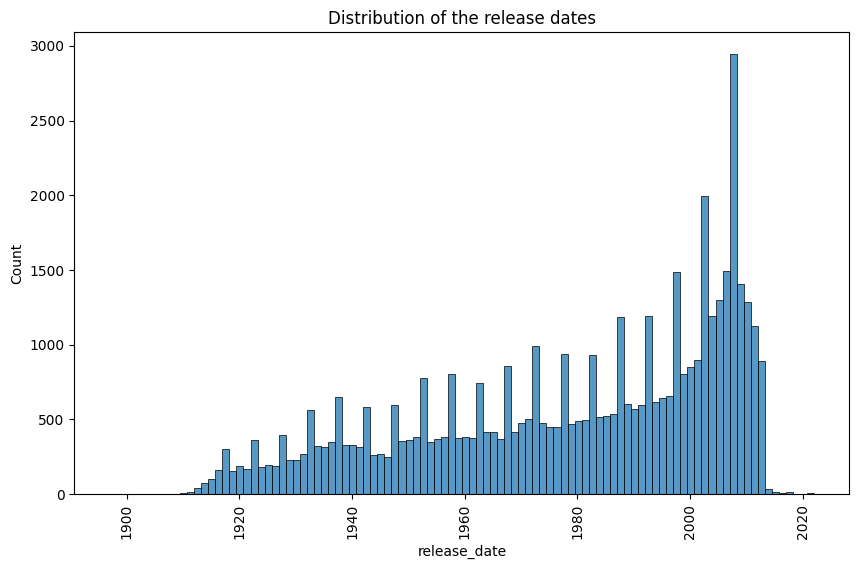

In [211]:
plt.figure(figsize=(10, 6))
sns.histplot(movies_with_actors, x = "release_date", bins = 100)
plt.xticks(rotation=90)  
plt.title('Distribution of the release dates')
plt.show()

In [159]:
movies_with_actors['genres_list'] = movies_with_actors['Movie_genres'].apply(
    lambda x: list(ast.literal_eval(x).values()) if pd.notna(x) else []
)

all_genres = [genre for sublist in movies_with_actors['genres_list'] for genre in sublist]

genre_counts = pd.DataFrame(all_genres, columns=['Genre']).value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

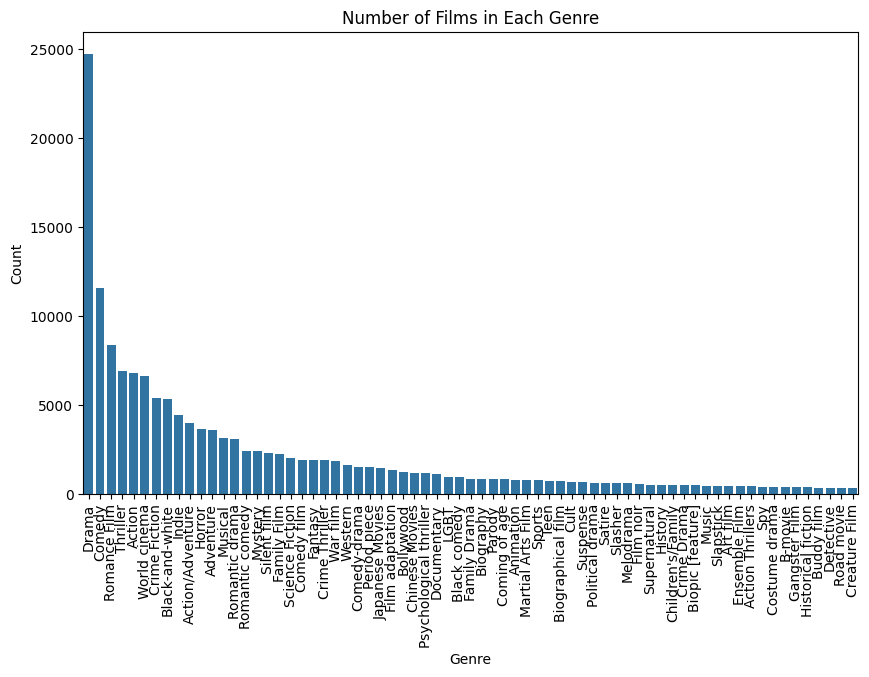

In [177]:
# Plot the count of genres
genre_counts = genre_counts[genre_counts.Count>300]

plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='Genre', y = 'Count')
plt.xticks(rotation=90)  
plt.title('Number of Films in Each Genre')
plt.show()

In [199]:
movies_with_actors['countries_list'] = movies_with_actors['Movie_countries'].apply(
    lambda x: list(ast.literal_eval(x).values()) if pd.notna(x) else []
)

all_countries = [countrie for sublist in movies_with_actors['countries_list'] for countrie in sublist]

countries_counts = pd.DataFrame(all_countries, columns=['Countries']).value_counts().reset_index()
countries_counts.columns = ['Countries', 'Count']

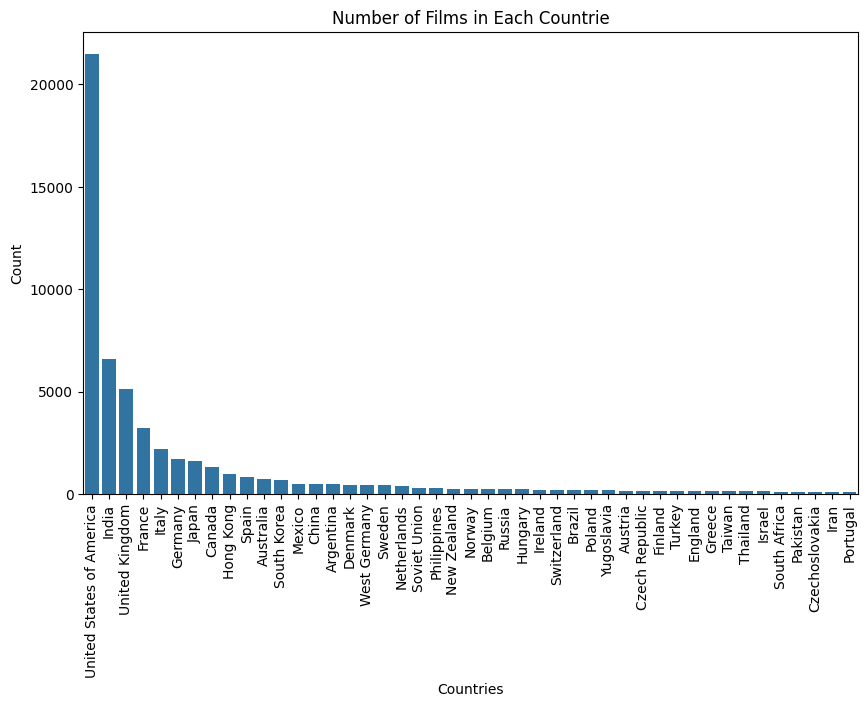

In [197]:
# Plot the count of genres
countries_counts = countries_counts[countries_counts.Count>100]

plt.figure(figsize=(10, 6))
sns.barplot(data=countries_counts, x='Countries', y = 'Count')
plt.xticks(rotation=90)  
plt.title('Number of Films in Each Countrie')
plt.show()

Use the `Characters` dataset to create an other dataset containing all the information for each actors

In [215]:
Actors = (
    Characters.groupby("Freebase_actor_ID")
    .agg({
        "Actor_Name": "first",  
        "Actor_DOB": "first",  
        "Actor_gender": "first",  
        "Actor_height": "first",
        "Actor_ethnicity": "first", 
        "Wikipedia_movie_ID": list, 
        "Freebase_movie_ID": list, 
        "Actor_age_at_movie_release": list, 
    })
    .reset_index() 
)

In [58]:
Actors.head()

,Freebase_actor_ID,Actor_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Wikipedia_movie_ID,Freebase_movie_ID,Actor_age_at_movie_release
0,/m/010p3,Adam Carolla,1964-05-27,M,1.88,/m/0xnvg,"[4209429, 2981197, 23760243, 1988341, 1988341,...","[/m/0bq2wj, /m/08hjr9, /m/06zm9p7, /m/06c5z_, ...","[35.0, 35.0, 45.0, 33.0, 33.0, 34.0, 42.0, 35...."
1,/m/010q36,Fred Rogers,1928-03-20,M,NaN,None,[21132353],[/m/033pf1],[67.0]
2,/m/010wx,Aria Giovanni,1977-11-03,F,1.68,/m/03q819,[2479658],[/m/07gx0c],[25.0]
3,/m/010xjr,Richard Harris,1930-10-01,M,1.85,/m/03bkbh,"[5021678, 2390369, 924954, 28686989, 28192781,...","[/m/0c_6bf, /m/078mm1, /m/03qfyt, /m/0cz7_4w, ...","[66.0, 46.0, nan, 59.0, 48.0, 39.0, 66.0, 50.0..."
4,/m/0112yl,Toshiro Mifune,1920-04-01,M,1.74,None,"[1432855, 21144547, 1358704, 312498, 16083779,...","[/m/0513nd, /m/05c2g3q, /m/04wjg1, /m/01tch8, ...","[31.0, 42.0, 45.0, 41.0, 62.0, 29.0, 30.0, 38...."


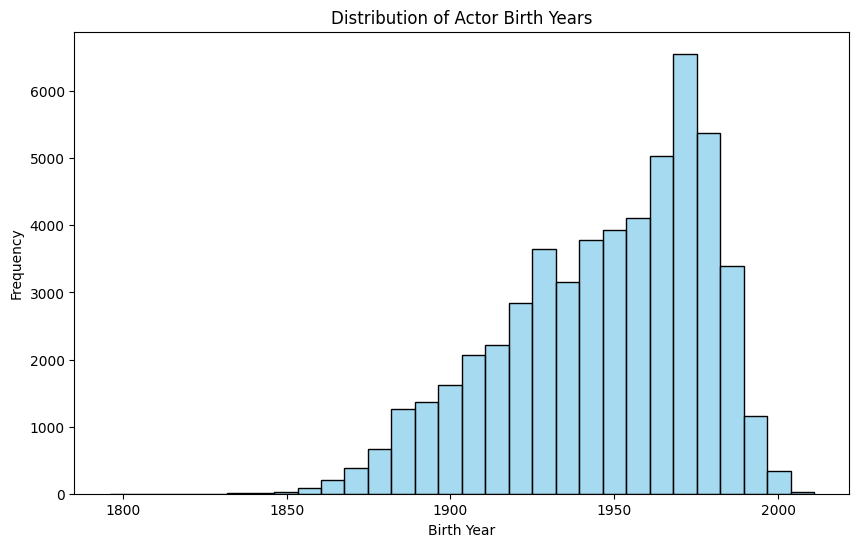

In [220]:
Actors['Actor_DOB'] = pd.to_datetime(Actors['Actor_DOB'], errors='coerce')
Actors['Birth_Year'] = Actors['Actor_DOB'].dt.year


plt.figure(figsize=(10, 6))
sns.histplot(Actors['Birth_Year'].dropna(), bins=30, color='skyblue')
plt.title('Distribution of Actor Birth Years')
plt.xlabel('Birth Year')
plt.ylabel('Frequency')
plt.show()

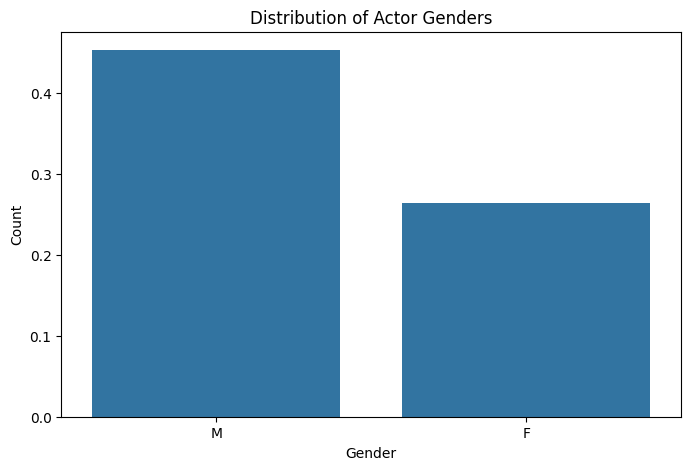

In [228]:
plt.figure(figsize=(8, 5))
sns.countplot(data=Actors, x='Actor_gender', stat = 'proportion')
plt.title('Distribution of Actor Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

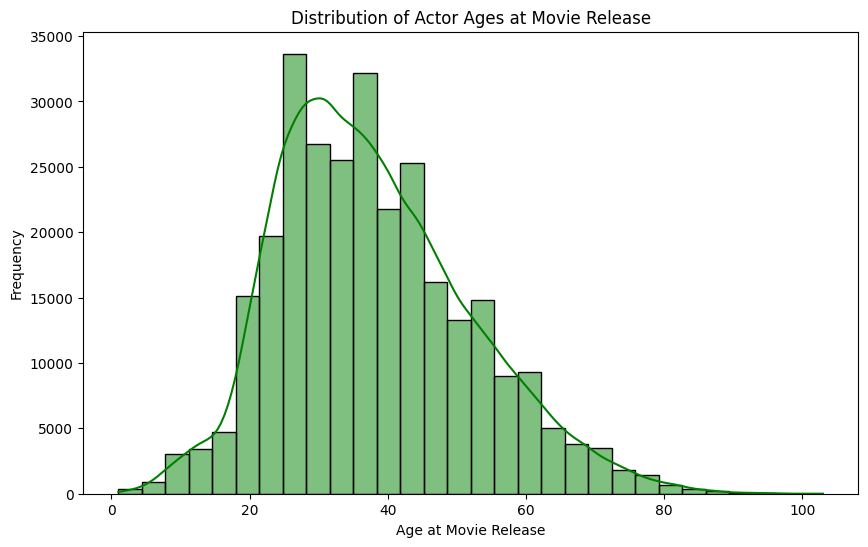

In [238]:
Actors_explo_age = Actors.explode('Actor_age_at_movie_release')
Actors_explo_age = Actors_explo_age[Actors_explo_age["Actor_age_at_movie_release"]>0]

plt.figure(figsize=(10, 6))
sns.histplot(Actors_explo_age['Actor_age_at_movie_release'], bins=30, kde=True, color='green')
plt.title('Distribution of Actor Ages at Movie Release')
plt.xlabel('Age at Movie Release')
plt.ylabel('Frequency')
plt.show()

Create a network where each node is an Actor ID and create edges between actors how played together

In [60]:
played_together = nx.Graph()


for _, row in tqdm(movies_with_actors.iterrows(), total=len(movies_with_actors)):
    actors_IDs = row['Actor_IDs']  
    release_date = row['Movie_release_date'] 

    for i in range(len(actors_IDs)):
        for j in range(i + 1, len(actors_IDs)):
            if actors_IDs[j] != actors_IDs[i]:  # Ensure no self-loops
                played_together.add_edge(
                    actors_IDs[i],
                    actors_IDs[j],
                    Release_date=release_date  
                )


100%|██████████| 48643/48643 [00:19<00:00, 2520.10it/s]


### 2. Extract metrics from the network

In [62]:
start = time.time()
degrees = dict(played_together.degree())
print(f"Computation time:{time.time()-start:.2f}")

Computation time:0.17


This is too expensive to compute. Maybe try an other library ?

start = time.time()
betweenness_centrality= nx.betweenness_centrality(played_together)
print(f"Computation time:{time.time()-start:.2f}")

In [128]:
start = time.time()
eigenvector_centrality = nx.eigenvector_centrality(played_together) 
print(f"Computation time:{time.time()-start:.2f}")

Computation time:29.53


### 3. Do the same for each year

Create sub graphs by keeping the edges that correspond to films that appears after a specific date

In [129]:
start = time.time()
cutoff_date = 2000

edges_to_keep = [
    (u, v) for u, v, data in played_together.edges(data=True)
    if data["Release_date"] < cutoff_date
]

# Create a subgraph with the filtered edges
played_together_2000 = played_together.edge_subgraph(edges_to_keep).copy()
print(f"The network for films before 2000 contains {played_together_2000.number_of_nodes()} with a total of {played_together_2000.number_of_edges()} connections.")
print(f"Computation time:{time.time()-start:.2f}")

The network for films before 2000 contains 71122 with a total of 997504 connections.
Computation time:14.34


In [130]:
start = time.time()
degrees_2000 = dict(played_together.degree())
print(f"Computation time:{time.time()-start:.2f}")

Computation time:0.10
